# Road Damage Model Identifier

### An Image Segmentation Project Using FastAi

In [3]:
# Import packages
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *

from fastai.vision.all import *
from fastai.basics import *
from fastai.callback.all import *

# fastai library doesn't just return a string containing the path to the dataset, but a Path object. 
# is a useful class from the Python 3 standard library that makes accessing files and directories much easier.
from pathlib import Path

In [4]:
path= Path()

In [10]:
# import the image and mask file paths 
fnames = get_image_files(path/"empty")
lbl_names = get_image_files(path/'empty')

In [ ]:
# goes through the mask files and stores a dictionary with each of the values. In our images we have black and white so
# will store two values
def n_codes(fnames, is_partial=True):
    "Gather the codes from a list of `fnames`"
    vals = set()
    if is_partial:
        random.shuffle(fnames) # take a random sample of the mask files
        fnames = fnames[:10] # select 10
    for fname in fnames:
        msk = np.array(PILMask.create(fname)) # creates an array with each of the levels in the png file
        for val in np.unique(msk): # find unique values in array (in this case just two values 0 (white) & 255 (black))
            if val not in vals:
                vals.add(val)
    vals = list(vals)
    p2c = dict()
    for i,val in enumerate(vals):
        p2c[i] = vals[i] #unique values are mapped sequentially to numbers starting at 0 -> {0:0, 1: 255}
    return p2c

#

In [ ]:
vals = n_codes(lbl_names)

In [ ]:
def get_my_y(fname:Path): 
    fn = path/'mask'/f'{fname.stem}.png'
    msk = np.array(PILMask.create(fn))
    mx = np.max(msk)
    for i, val in enumerate(vals):
        msk[msk==vals[i]] = val
    return PILMask.create(msk)


In [ ]:
# labels used in datablock
codes = ['good', 'damage']

In [ ]:
# Data Block is essentially the equivalent to the pipeline in Scikit Learn.
# A DataBlock is just a blue print on how to assemble your data. It does not do anything until you pass it a source. 
# You can choose to then convert that source into a Datasets or a DataLoaders by using the DataBlock.datasets or 
# DataBlock.dataloaders method.

# To build a DataBlock you need to give the library four things: 
# the types of your input/labels, and at least two functions: get_items and splitter.


ds = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files, # where is the data
                   splitter=RandomSplitter(), # how to split data. Usually a random split between the training and validation dataset.
                   get_y=get_my_y, # what to apply to the outputs
                   item_tfms=Resize(224), # item transform applied on an individual item basis. This is done on the CPU.
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]) # is batch transform applied on batches of data. This is done in GPU.

# note on batch transformation
# .normalize normalises the data. Neural nets want  data to have a mean of zero and a standard deviation of 1. 
# done by subracting from each score the mean of the variable and then deviding it by the standard deviation of 
# that variable. 
# The mean and sd of the imagenet data are stored in the imagenet_stat variable.
# (Note that if you use the imagenet pretrained model. You do not want to use the mean and standard 
# deviations of your data but the mean and standard deviation of the original imagenet data.)

In [ ]:
# create the dataloader from the datablock
dls = ds.dataloaders(path/'images', bs=4)
# bs (int): how many samples per batch to load

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
# A traditional CNN won't work for segmentation, therfore use a special kind of model called a UNet, 
# Convolutional neural network; a type of neural network that works particularly well for computer vision tasks
# Creating the model setup (not actually fitting it here)
learn = unet_learner(dls, resnet50)

In [ ]:
# load the model that was saved above
# note that its required that the learn object i.e. the model is created before doing this (this was done above)
learn = learn.load('model_tune')

In [ ]:
# OpenCV-Python is a library of Python bindings designed to solve computer vision problems.
# had to run the following installations in addition to enable opencv-python to run on paperspace
# need to run in terminal as can't answer y/n in jupyter

# apt-get update
# apt-get upgrade
# apt install libgl1-mesa-glx
# pip install opencv-python 
import cv2 #import opencv-python (uses the old name still for import)


#### Upload Image

In [ ]:
img_uploaded = widgets.FileUpload()
img_uploaded

FileUpload(value={}, description='Upload')

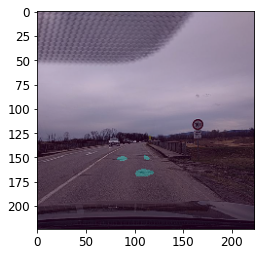

In [ ]:
button = widgets.Button(description='Identify Damage')
out = widgets.Output()
def on_button_clicked(_):
    # "linking function with output"
    with out:
      # what happens when we press the button
        pred = learn.predict(img_uploaded.data[-1])
        plt.imsave('solution.png', pred[0]) #Save an array as an image file.
        img1 = np.array(PILImage.create(img_uploaded.data[-1]))
        img2 = cv2.imread('solution.png')
        img1=cv2.resize(img1, (224,224))
        img2=cv2.resize(img2, (224,224))

        result = cv2.addWeighted(img1, 0.7, img2, 0.3, 0)
        print('computing...')
        plt.imshow(result)


        
# linking button and function together using a button's method
button.on_click(on_button_clicked)
# displaying button and its output together
widgets.VBox([button,out])